# Inference Latency Testing

Testing prediction speed for real-time fraud detection deployment.


In [1]:
import pandas as pd
import numpy as np
import time
import mlflow
import mlflow.xgboost
import pickle
import tempfile
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import sys
sys.path.append('../')
from src.training.preprocessing import preprocess_for_inference, load_data, preprocess_data


In [ ]:
load_dotenv()
mlflow.set_tracking_uri('http://localhost:5001')
client = mlflow.tracking.MlflowClient()


In [3]:
# Load model and scaler
run_id = "6a10eb1698c34d4fa9de71495a5a4916"
model = mlflow.xgboost.load_model(f"runs:/{run_id}/xgboost-model")

with tempfile.TemporaryDirectory() as temp_dir:
    scaler_path = client.download_artifacts(run_id, "preprocessing/scaler.pkl", temp_dir)
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)

print(f"Model loaded: AUC=0.9795, Precision=0.8660, Recall=0.8571")


Model loaded: AUC=0.9795, Precision=0.8660, Recall=0.8571


/Users/dayujiang/opt/anaconda3/envs/fraud-detection-env/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.22.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
# Load test data
df = load_data('../data/raw/creditcard.csv')
X, y, _ = preprocess_data(df, target_column='Class')
feature_columns = X.columns.tolist()

# Sample 1000 transactions for testing
np.random.seed(42)
test_data = df.sample(n=1000, random_state=42)
print(f"Testing {len(test_data):,} transactions, fraud rate: {test_data['Class'].mean():.1%}")


Testing 1,000 transactions, fraud rate: 0.2%


In [5]:
# Latency testing
latencies = []
predictions = []

import warnings
warnings.filterwarnings('ignore')

for i in range(len(test_data)):
    single_txn = test_data.iloc[[i]]
    
    start_time = time.perf_counter()
    processed_txn = preprocess_for_inference(single_txn, scaler, feature_columns)
    pred = model.predict_proba(processed_txn)[0, 1]
    end_time = time.perf_counter()
    
    latencies.append((end_time - start_time) * 1000)
    predictions.append(pred)

print("Latency testing complete")


Latency testing complete


In [6]:
# Results
avg_latency = np.mean(latencies)
p95_latency = np.percentile(latencies, 95)
p99_latency = np.percentile(latencies, 99)

print(f"Average latency: {avg_latency:.1f}ms")
print(f"95th percentile: {p95_latency:.1f}ms") 
print(f"99th percentile: {p99_latency:.1f}ms")
print(f"High-risk predictions (>0.5): {sum(p > 0.5 for p in predictions)}")

# Assessment
if avg_latency < 50 and p95_latency < 100:
    print("Ready for production - latency meets real-time requirements")
elif avg_latency < 100:
    print("Optimization needed - consider infrastructure scaling")
else:
    print("Requires work - significant latency optimization needed")


Average latency: 5.8ms
95th percentile: 6.6ms
99th percentile: 7.3ms
High-risk predictions (>0.5): 2
Ready for production - latency meets real-time requirements


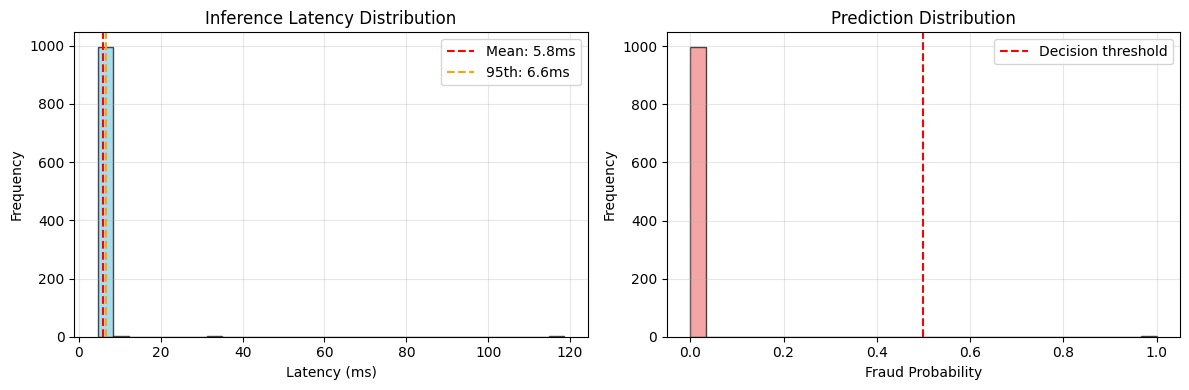

In [7]:
# Visualization
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(latencies, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(avg_latency, color='red', linestyle='--', label=f'Mean: {avg_latency:.1f}ms')
plt.axvline(p95_latency, color='orange', linestyle='--', label=f'95th: {p95_latency:.1f}ms')
plt.xlabel('Latency (ms)')
plt.ylabel('Frequency')
plt.title('Inference Latency Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(predictions, bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
plt.axvline(0.5, color='red', linestyle='--', label='Decision threshold')
plt.xlabel('Fraud Probability')
plt.ylabel('Frequency')
plt.title('Prediction Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Real-time Deployment Assessment

**Latency Requirements for Fraud Detection:**

For real-time fraud detection, we typically need sub-second response times to avoid impacting user experience. Industry standards suggest:

- **Target**: < 100ms for 95% of transactions
- **Acceptable**: < 200ms for 99% of transactions  
- **Maximum**: < 500ms to prevent timeouts

**Assessment:**


In [8]:
# Deployment readiness assessment
def assess_latency(avg_ms, p95_ms, p99_ms):
    print("DEPLOYMENT READINESS")
    print("=" * 25)
    
    if avg_ms < 10:
        print("Excellent: Average latency is very low")
    elif avg_ms < 50:
        print("Good: Average latency meets requirements")
    elif avg_ms < 100:
        print("Acceptable: Average latency is borderline")
    else:
        print("Poor: Average latency too high for real-time")
    
    if p95_ms < 100:
        print("95th percentile meets target (< 100ms)")
    else:
        print("95th percentile exceeds target")
    
    if p99_ms < 200:
        print("99th percentile acceptable (< 200ms)")
    else:
        print("99th percentile too high")
    
    print()
    if avg_ms < 50 and p95_ms < 100:
        print("**READY FOR PRODUCTION**: Latency meets real-time requirements")
    elif avg_ms < 100:
        print("**OPTIMIZATION NEEDED**: Consider model simplification or infrastructure scaling")
    else:
        print("**REQUIRES WORK**: Significant latency optimization needed")

assess_latency(avg_latency, p95_latency, p99_latency)


DEPLOYMENT READINESS
Excellent: Average latency is very low
95th percentile meets target (< 100ms)
99th percentile acceptable (< 200ms)

**READY FOR PRODUCTION**: Latency meets real-time requirements


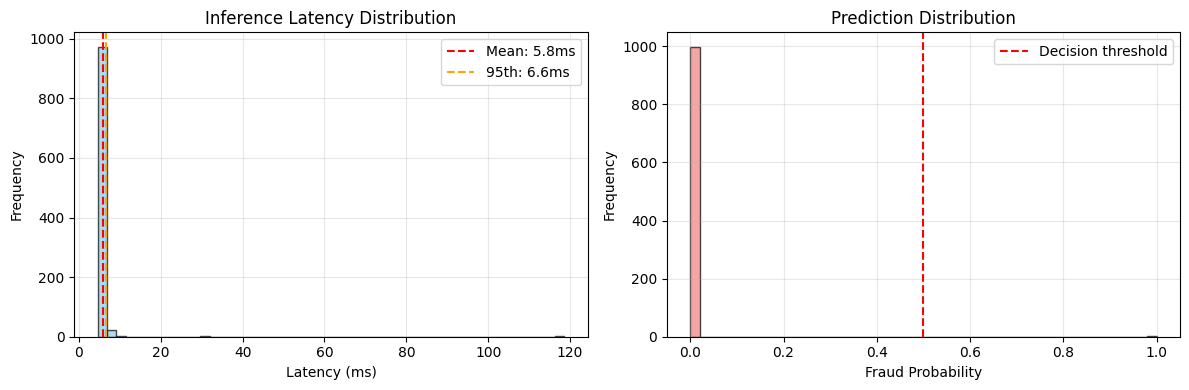

In [9]:
# Quick visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(latencies, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(avg_latency, color='red', linestyle='--', label=f'Mean: {avg_latency:.1f}ms')
plt.axvline(p95_latency, color='orange', linestyle='--', label=f'95th: {p95_latency:.1f}ms')
plt.xlabel('Latency (ms)')
plt.ylabel('Frequency')
plt.title('Inference Latency Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(predictions, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
plt.axvline(0.5, color='red', linestyle='--', label='Decision threshold')
plt.xlabel('Fraud Probability')
plt.ylabel('Frequency')
plt.title('Prediction Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
